In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:45 - loss: 0.1344 - STD: 1.0936e-04 - MAE: 0.3552

 11/632 [..............................] - ETA: 3s - loss: 0.0392 - STD: 2.3776e-04 - MAE: 0.1537   

 21/632 [..............................] - ETA: 3s - loss: 0.0290 - STD: 2.1484e-04 - MAE: 0.1267

 31/632 [>.............................] - ETA: 3s - loss: 0.0241 - STD: 2.0931e-04 - MAE: 0.1105

 41/632 [>.............................] - ETA: 3s - loss: 0.0214 - STD: 2.1836e-04 - MAE: 0.0996

 51/632 [=>............................] - ETA: 3s - loss: 0.0197 - STD: 2.4546e-04 - MAE: 0.0949

 62/632 [=>............................] - ETA: 3s - loss: 0.0185 - STD: 2.9458e-04 - MAE: 0.0901

 73/632 [==>...........................] - ETA: 2s - loss: 0.0177 - STD: 3.8051e-04 - MAE: 0.0874

 85/632 [===>..........................] - ETA: 2s - loss: 0.0169 - STD: 5.5145e-04 - MAE: 0.0848

 97/632 [===>..........................] - ETA: 2s - loss: 0.0163 - STD: 8.9631e-04 - MAE: 0.0826

109/632 [====>.........................] - ETA: 2s - loss: 0.0157 - STD: 0.0017 - MAE: 0.0807    

121/632 [====>.........................] - ETA: 2s - loss: 0.0152 - STD: 0.0035 - MAE: 0.0788

133/632 [=====>........................] - ETA: 2s - loss: 0.0145 - STD: 0.0074 - MAE: 0.0763

145/632 [=====>........................] - ETA: 2s - loss: 0.0136 - STD: 0.0132 - MAE: 0.0735

157/632 [======>.......................] - ETA: 2s - loss: 0.0129 - STD: 0.0194 - MAE: 0.0707

169/632 [=======>......................] - ETA: 2s - loss: 0.0122 - STD: 0.0251 - MAE: 0.0683

181/632 [=======>......................] - ETA: 2s - loss: 0.0116 - STD: 0.0299 - MAE: 0.0661

193/632 [========>.....................] - ETA: 2s - loss: 0.0110 - STD: 0.0341 - MAE: 0.0641

205/632 [========>.....................] - ETA: 1s - loss: 0.0105 - STD: 0.0379 - MAE: 0.0622

217/632 [=========>....................] - ETA: 1s - loss: 0.0101 - STD: 0.0412 - MAE: 0.0606

229/632 [=========>....................] - ETA: 1s - loss: 0.0097 - STD: 0.0444 - MAE: 0.0591

240/632 [==========>...................] - ETA: 1s - loss: 0.0093 - STD: 0.0469 - MAE: 0.0578

251/632 [==========>...................] - ETA: 1s - loss: 0.0090 - STD: 0.0494 - MAE: 0.0566

261/632 [===========>..................] - ETA: 1s - loss: 0.0087 - STD: 0.0513 - MAE: 0.0556

271/632 [===========>..................] - ETA: 1s - loss: 0.0085 - STD: 0.0532 - MAE: 0.0547

281/632 [============>.................] - ETA: 1s - loss: 0.0083 - STD: 0.0549 - MAE: 0.0538

293/632 [============>.................] - ETA: 1s - loss: 0.0080 - STD: 0.0568 - MAE: 0.0528

305/632 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.0586 - MAE: 0.0519

317/632 [==============>...............] - ETA: 1s - loss: 0.0075 - STD: 0.0602 - MAE: 0.0510

329/632 [==============>...............] - ETA: 1s - loss: 0.0073 - STD: 0.0618 - MAE: 0.0502

341/632 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0633 - MAE: 0.0495

353/632 [===============>..............] - ETA: 1s - loss: 0.0069 - STD: 0.0645 - MAE: 0.0488

366/632 [================>.............] - ETA: 1s - loss: 0.0068 - STD: 0.0659 - MAE: 0.0481

378/632 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0670 - MAE: 0.0475

391/632 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0682 - MAE: 0.0468

403/632 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0693 - MAE: 0.0463

406/632 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0695 - MAE: 0.0462

417/632 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0704 - MAE: 0.0457

428/632 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.0713 - MAE: 0.0453

439/632 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0721 - MAE: 0.0448

451/632 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0729 - MAE: 0.0444

463/632 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0440

475/632 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0746 - MAE: 0.0435

487/632 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0753 - MAE: 0.0432

499/632 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0428

511/632 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0767 - MAE: 0.0425

523/632 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0421

535/632 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0779 - MAE: 0.0418

547/632 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0415

559/632 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0412

571/632 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0409

583/632 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0406

595/632 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0404

607/632 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0402

619/632 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0399

631/632 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0397

632/632 [==============================] - 5s 6ms/step - loss: 0.0046 - STD: 0.0820 - MAE: 0.0397 - val_loss: 0.0016 - val_STD: 0.0769 - val_MAE: 0.0289


Epoch 2/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0303

 12/632 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0279 

 24/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0277

 36/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0274

 48/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0273

 60/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0272

 72/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0272

 84/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0272

 97/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

109/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

121/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

133/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

145/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

157/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

169/632 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

181/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

193/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

205/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

218/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

231/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

243/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

255/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

267/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

279/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

291/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

303/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

315/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

327/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

339/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

351/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

362/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

374/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

386/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

398/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

410/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

422/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

434/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

446/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

458/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

470/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

482/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

494/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

505/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

517/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

529/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

541/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

553/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

565/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

577/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

589/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

601/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

612/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

624/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.0809 - val_MAE: 0.0290


Epoch 3/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0257

 11/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0271 

 23/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0268

 35/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0269

 47/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

 59/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

 70/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

 81/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0266

 93/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

105/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

117/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

129/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

141/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

153/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

165/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

177/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

189/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

201/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

213/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

225/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

237/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

249/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

261/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

273/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

283/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

294/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

305/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

315/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

325/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

335/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

345/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

355/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

366/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

377/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

387/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

398/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

410/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

422/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

434/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

445/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

455/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

465/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

475/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

485/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

496/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

508/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

519/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

530/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

541/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

552/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

564/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

575/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

586/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

598/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

610/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

622/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263 - val_loss: 0.0015 - val_STD: 0.0787 - val_MAE: 0.0272


Epoch 4/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0013 - STD: 0.1004 - MAE: 0.0256

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1041 - MAE: 0.0250 

 21/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0253

 32/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

 44/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

 56/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

 68/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

 79/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

 91/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

103/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

113/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

123/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

133/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

144/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

154/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

164/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

174/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

185/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

195/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

205/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

215/632 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

225/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

236/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

247/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

257/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

267/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

277/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

287/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

297/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

318/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

329/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

341/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

354/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

367/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

380/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

392/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

404/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

416/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

428/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

440/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

452/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

464/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

476/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

488/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

500/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

512/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

524/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

536/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

548/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

560/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

572/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

584/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

597/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

610/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

622/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259 - val_loss: 0.0015 - val_STD: 0.0833 - val_MAE: 0.0277


Epoch 5/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1107 - MAE: 0.0276

 11/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0267 

 21/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

 32/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0262

 44/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0260

 57/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

 69/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

 81/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

 93/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

105/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

117/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

130/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

142/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

154/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

166/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

178/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

190/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

202/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

214/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

226/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

238/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

251/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

263/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

275/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

287/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

299/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

311/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

323/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

335/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

347/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

359/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

371/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

383/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

394/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

404/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

417/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

430/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

443/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

456/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

469/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

482/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

495/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

506/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

518/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

530/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

542/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

554/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

566/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

578/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

590/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

603/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

615/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

628/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255 - val_loss: 0.0014 - val_STD: 0.0823 - val_MAE: 0.0266


Epoch 6/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1011 - MAE: 0.0258

 12/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0246 

 23/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0245

 34/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

 44/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0251

 56/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

 68/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

 80/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

 92/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

104/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

115/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

125/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

136/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

148/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

160/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

172/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

184/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

196/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

208/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

220/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

231/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

243/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

255/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

267/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

279/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

291/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

303/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

315/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

327/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

339/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

351/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

363/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

375/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

386/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

396/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

406/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

416/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

427/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

439/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

449/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

461/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

471/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

483/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

495/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

507/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

519/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

531/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

543/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

555/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

567/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

580/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

592/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

604/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

616/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

627/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251 - val_loss: 0.0017 - val_STD: 0.0856 - val_MAE: 0.0286


Epoch 7/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0012 - STD: 0.1019 - MAE: 0.0242

 12/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0240 

 23/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

 35/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0245

 48/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

 60/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0245

 71/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0244

 82/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

 92/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

104/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0245

117/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

130/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

143/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

155/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

167/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

178/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

188/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

198/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

209/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

220/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

230/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

240/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

250/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

261/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

273/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

286/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

299/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

311/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

323/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

335/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

347/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

359/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

371/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

384/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

396/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

407/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

418/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

430/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

442/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

452/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

464/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

476/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

488/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

500/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

512/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

524/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

536/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

548/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

560/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

572/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

584/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

596/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

608/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

620/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

632/632 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246 - val_loss: 0.0026 - val_STD: 0.0911 - val_MAE: 0.0337


Epoch 8/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1240 - MAE: 0.0252

 13/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0246 

 25/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0245

 38/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0246

 50/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0246

 62/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0245

 74/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0244

 83/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0244

 95/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0243

105/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0243

117/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0242

129/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0242

142/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

155/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

167/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

179/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0241

191/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0241

203/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0241

215/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

226/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

238/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

250/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

262/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

274/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

286/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

298/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

308/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

319/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

330/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

342/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

354/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

366/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

378/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

390/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

402/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

414/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

426/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0242

438/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

450/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

462/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

474/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

486/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

499/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

511/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

523/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

535/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

547/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

559/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

570/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

581/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

592/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

604/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

616/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

627/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242 - val_loss: 0.0020 - val_STD: 0.0862 - val_MAE: 0.0304


Epoch 9/10000


  1/632 [..............................] - ETA: 12s - loss: 9.9138e-04 - STD: 0.1044 - MAE: 0.0223

 12/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235     

 24/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0235

 35/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0237

 46/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0236

 58/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0236

 70/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0236

 82/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0235

 94/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0236

105/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0236

117/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0236

129/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0236

141/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0236

153/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0236

165/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

177/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

189/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

201/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

213/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

225/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0235

237/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

249/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

261/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0236

273/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

285/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0237

297/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

309/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

321/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

333/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

345/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

357/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

369/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

381/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

393/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

405/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

417/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

429/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

441/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0237

453/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

465/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

477/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

489/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

500/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

512/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

524/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

537/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

549/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

561/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

572/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

583/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

594/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

606/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

619/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

631/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236 - val_loss: 0.0018 - val_STD: 0.0872 - val_MAE: 0.0284


Epoch 10/10000


  1/632 [..............................] - ETA: 15s - loss: 9.9917e-04 - STD: 0.1131 - MAE: 0.0227

 13/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1062 - MAE: 0.0236     

 24/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1054 - MAE: 0.0235

 36/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0234

 48/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0233

 60/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0232

 72/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0231

 84/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0231

 96/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0231

108/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

119/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

130/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

140/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

150/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

160/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

170/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

180/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

191/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

202/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

213/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

225/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

236/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

247/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

259/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

271/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

282/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

291/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

301/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

311/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

322/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

333/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

343/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

353/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

363/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

374/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

385/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

397/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

409/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

419/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

429/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

439/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

449/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

459/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

469/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

479/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

490/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

500/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

510/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

519/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

529/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

539/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

549/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

560/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

571/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

581/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

591/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

601/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

611/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

621/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

631/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235 - val_loss: 0.0019 - val_STD: 0.0866 - val_MAE: 0.0291


Epoch 11/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0010 - STD: 0.1100 - MAE: 0.0228

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0230 

 23/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0233

 36/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0233

 48/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0232

 59/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0232

 70/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0232

 81/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0232

 93/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

106/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

117/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

129/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

141/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0231

153/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0231

166/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0232

179/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0231

192/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

205/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

218/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

230/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

242/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

254/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

266/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

278/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

290/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

302/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

314/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

326/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

338/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

350/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

362/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

374/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

386/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

398/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

409/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

420/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

430/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

441/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

454/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

466/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

478/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

490/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

502/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

514/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

525/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

536/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

547/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

559/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

571/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

583/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

595/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

607/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

619/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

631/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230 - val_loss: 0.0018 - val_STD: 0.0860 - val_MAE: 0.0283


Epoch 12/10000


  1/632 [..............................] - ETA: 12s - loss: 9.7801e-04 - STD: 0.1038 - MAE: 0.0220

 13/632 [..............................] - ETA: 2s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224     

 25/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1071 - MAE: 0.0225

 37/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0229

 49/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0229

 60/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

 70/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

 81/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

 93/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

105/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

117/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

129/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0230

141/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0230

153/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

165/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

177/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0229

189/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0229

201/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0229

213/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

226/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0229

239/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0229

251/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

263/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

275/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

287/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

299/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

311/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

323/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0228

335/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

347/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

359/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

371/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

383/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

395/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

407/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

419/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

431/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

443/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

455/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

467/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

479/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

491/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

503/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0227

515/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

527/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

539/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

551/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

563/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

576/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

588/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

600/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

612/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

624/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

632/632 [==============================] - 3s 5ms/step - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227 - val_loss: 0.0015 - val_STD: 0.0830 - val_MAE: 0.0266


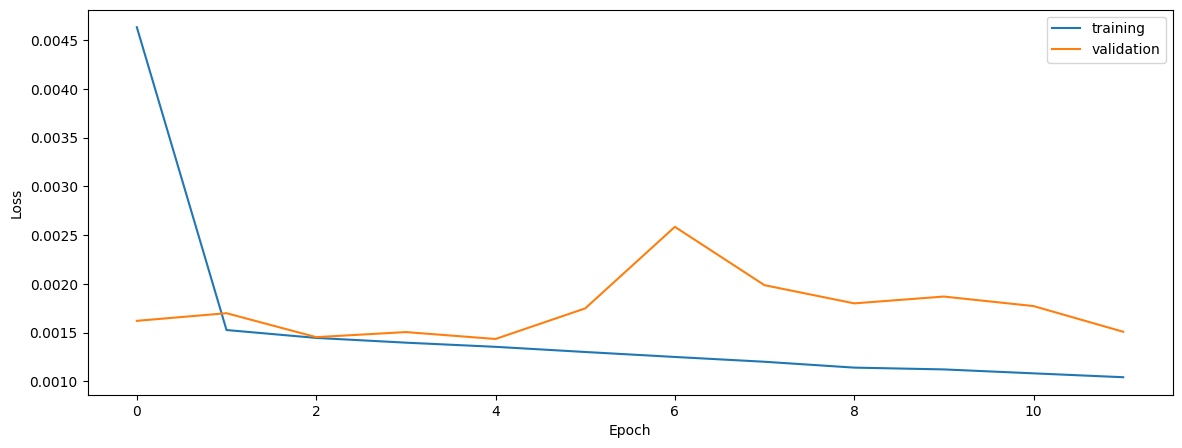

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9489751751623897
0.9584171422966998
0.9476678267685338


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9488013117122919
0.9549348535382952
0.9511278810371039


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.955052373275133
0.9564884969485417
0.9623805349296779


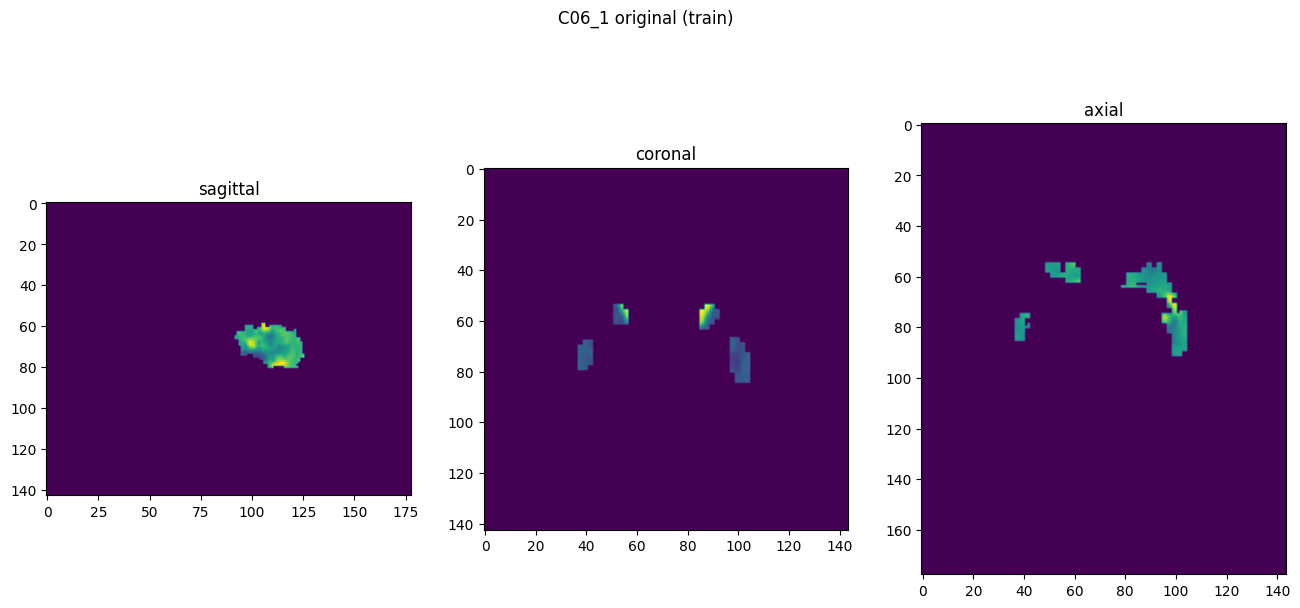

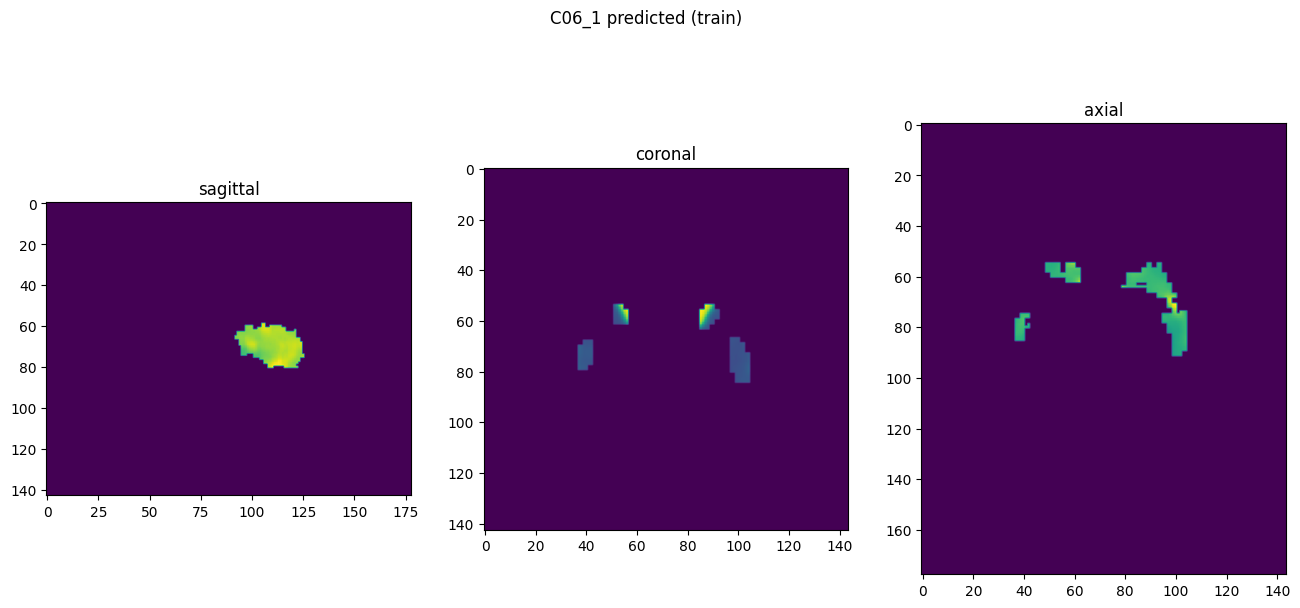

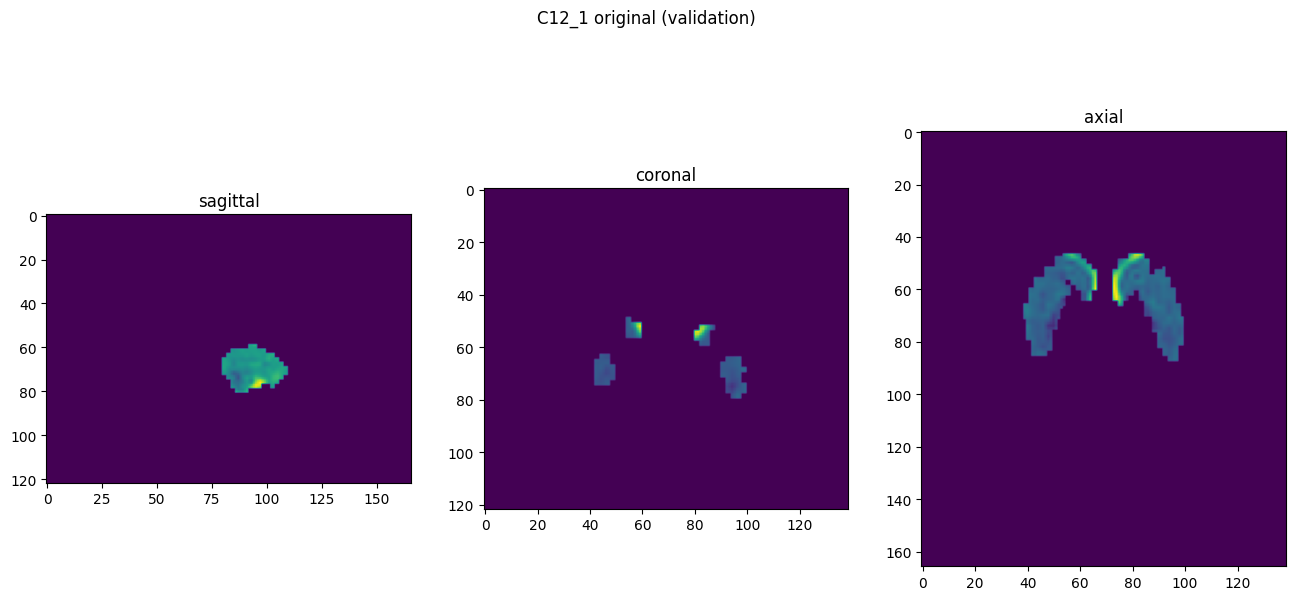

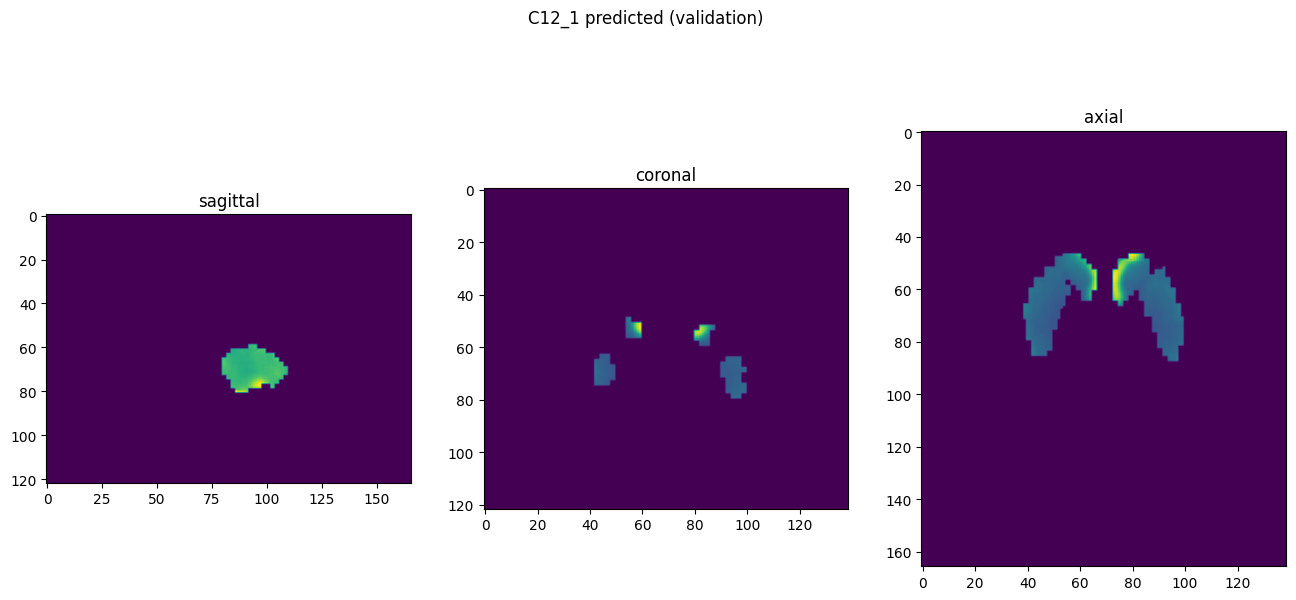

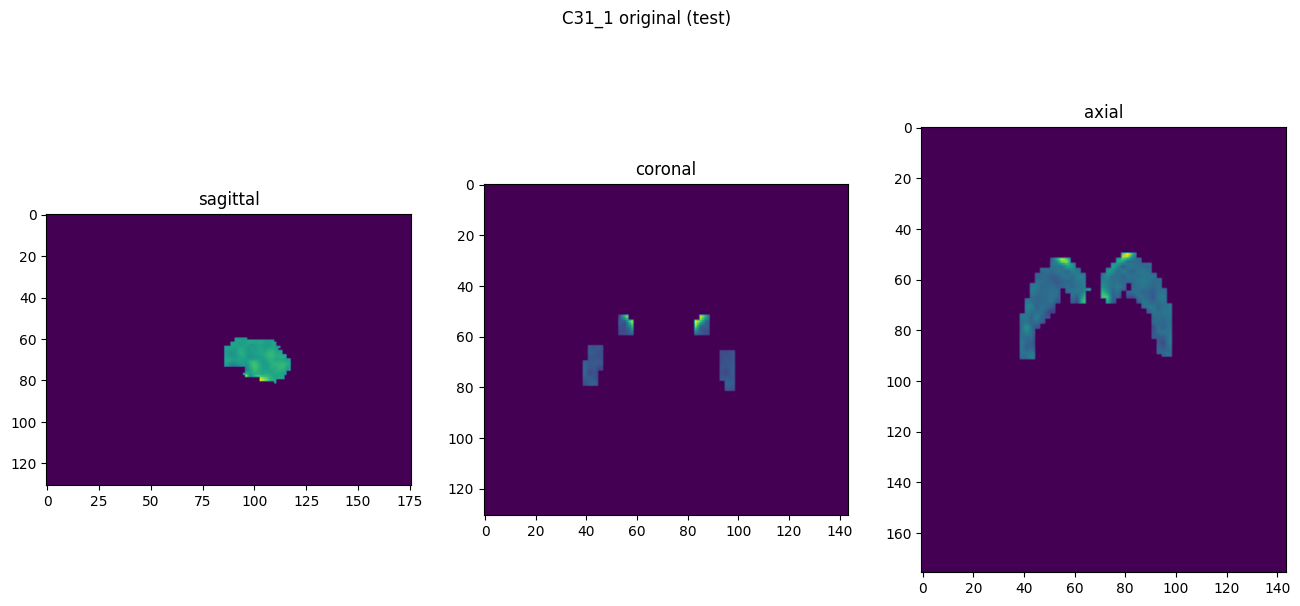

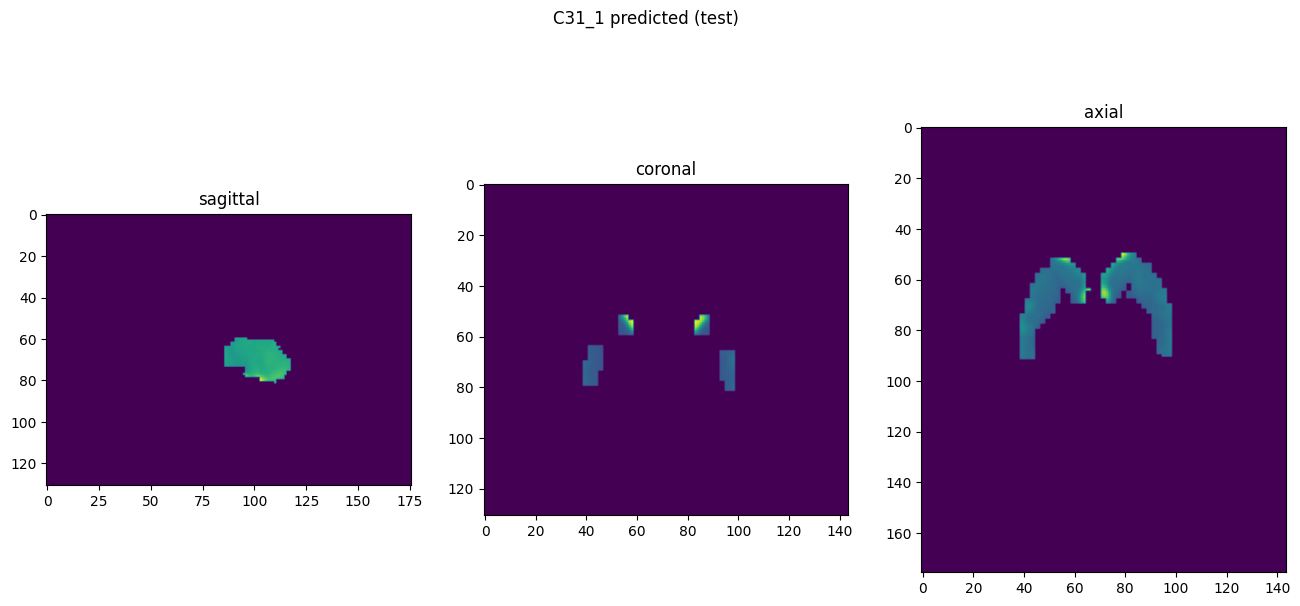

In [10]:
showResults(model, gen, threshold=None, background=False)